In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, make_scorer, confusion_matrix
from scipy import stats # Para intervalo de confiança

# --- Carregar Dados (usar o conjunto .train como base) ---
try:
    data_file_test = r'C:\Users\pedro\OneDrive\Documentos\dev\python\A.M\data\SPECTF.test'
    data_file_train = r'C:\Users\pedro\OneDrive\Documentos\dev\python\A.M\data\SPECTF.train'
    col_names = ['target'] + [f'feature_{i}' for i in range(1, 45)]
    data_df_test = pd.read_csv(data_file_test, header=None, names=col_names, sep=',')
    data_df_train = pd.read_csv(data_file_train, header=None, names=col_names, sep=',')
    data_df = pd.concat([data_df_train, data_df_test], ignore_index=True)
    print(f"Dataset carregado: {data_df.shape[0]} amostras, {data_df.shape[1]-1} features")

    X = data_df.iloc[:, 1:].values
    y = data_df.iloc[:, 0].values

    # Verificar distribuição das classes
    unique, counts = np.unique(y, return_counts=True)
    print("Distribuição das classes:", dict(zip(unique, counts)))

except FileNotFoundError:
    print(f"Erro: Arquivos não encontrados.")
    print("Por favor, baixe o dataset SPECTF do repositório UCI ML e coloque-o no diretório.")
    exit()

Dataset carregado: 267 amostras, 44 features
Distribuição das classes: {np.int64(0): np.int64(55), np.int64(1): np.int64(212)}


In [8]:
from src.gaussian_bayesian_classifier import GaussianBayesClassifier
from scipy.linalg import LinAlgError
# --- 3. Validação Cruzada 30x10 ---
print("\n--- Iniciando Validação Cruzada 30x10 ---")

n_splits = 10
n_repeats = 30
rskf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)

# Métricas a serem coletadas
# Usaremos macro average pois é um caso binário, mas funciona para multi-classe
# O scikit-learn calcula precisão/recall/f1 por classe e depois faz a média
# 'accuracy' é a taxa de acerto global
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_recall_fscore_support, average='macro', pos_label=1, zero_division=0), # Índice 0 é precisão
    'recall': make_scorer(precision_recall_fscore_support, average='macro', pos_label=1, zero_division=0),    # Índice 1 é recall (cobertura)
    'f1': make_scorer(precision_recall_fscore_support, average='macro', pos_label=1, zero_division=0)        # Índice 2 é F1-score
}
# Nota: O make_scorer retorna uma tupla, precisamos pegar o elemento correto.
#       Ou podemos definir funções lambda para cada métrica.

# Dicionário para armazenar os scores de cada métrica em todas as folds
all_scores = {metric: [] for metric in ['accuracy', 'error_rate', 'precision', 'recall', 'f1']}

fold_count = 0
for train_index, test_index in rskf.split(X, y):
    fold_count += 1
    if fold_count % 30 == 0: # Print a cada 10 folds (1 repetição)
         print(f"Processando Fold {fold_count}/{n_splits*n_repeats}...")

    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Instanciar e treinar o modelo
    model = GaussianBayesClassifier(reg_epsilon=1e-6)
    try:
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_test_fold)

        # Calcular métricas para este fold
        acc = accuracy_score(y_test_fold, y_pred_fold)
        # Precisão, Recall, F1 (macro) - retorna P, R, F, Support
        # Precisamos ter cuidado com divisões por zero se uma classe não for prevista
        # O average='macro' calcula para cada classe e tira a média não ponderada
        # zero_division=0 evita warnings e retorna 0 se houver divisão por zero
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test_fold, y_pred_fold, average='macro', zero_division=0
        )

        # Armazenar métricas
        all_scores['accuracy'].append(acc)
        all_scores['error_rate'].append(1 - acc)
        all_scores['precision'].append(precision)
        all_scores['recall'].append(recall) # Recall é a Cobertura
        all_scores['f1'].append(f1)         # F1 é o F-measure

    except LinAlgError as e:
        print(f"AVISO: Falha ao treinar/prever no fold {fold_count} devido a erro de álgebra linear: {e}. Pulando este fold.")
        # Podemos adicionar NaN ou pular, aqui vamos pular para o cálculo da média
        # Adicionar NaNs pode ser melhor para manter o N=300 se quisermos usar t-student exato
        # all_scores['accuracy'].append(np.nan)
        # ... etc para outras métricas
        pass # Pula para o próximo fold
    except Exception as e:
        print(f"AVISO: Erro inesperado no fold {fold_count}: {e}. Pulando este fold.")
        pass

print("--- Validação Cruzada Concluída ---")

# --- 4. Estimativas Pontuais e Intervalos de Confiança ---
print("\n--- Resultados da Validação Cruzada (Baseado em Folds Válidos) ---")

results_summary = {}
alpha = 0.05 # Para IC de 95%

for metric_name, scores in all_scores.items():
    valid_scores = np.array(scores)[~np.isnan(scores)] # Remover NaNs se houver
    n_valid_folds = len(valid_scores)

    if n_valid_folds < 2: # Precisa de pelo menos 2 pontos para std dev
        print(f"Métrica '{metric_name}': Não há folds válidos suficientes ({n_valid_folds}) para calcular estatísticas.")
        results_summary[metric_name] = {'mean': np.nan, 'std_dev': np.nan, 'ci': (np.nan, np.nan), 'n_valid': n_valid_folds}
        continue

    mean_score = np.mean(valid_scores)
    std_dev_score = np.std(valid_scores, ddof=1) # ddof=1 para desvio padrão amostral
    sem_score = std_dev_score / np.sqrt(n_valid_folds) # Erro padrão da média

    # Calcular intervalo de confiança usando t-distribuição
    # Graus de liberdade = n_valid_folds - 1
    t_crit = stats.t.ppf(1.0 - alpha / 2.0, n_valid_folds - 1)
    ci_lower = mean_score - t_crit * sem_score
    ci_upper = mean_score + t_crit * sem_score

    print(f"Métrica: {metric_name.replace('_', ' ').title()}")
    print(f"  - Número de Folds Válidos: {n_valid_folds}")
    print(f"  - Média (Estimativa Pontual): {mean_score:.4f}")
    print(f"  - Desvio Padrão: {std_dev_score:.4f}")
    print(f"  - Intervalo de Confiança 95%: ({ci_lower:.4f}, {ci_upper:.4f})")

    results_summary[metric_name] = {
        'mean': mean_score,
        'std_dev': std_dev_score,
        'ci': (ci_lower, ci_upper),
        'n_valid': n_valid_folds
    }


--- Iniciando Validação Cruzada 30x10 ---
Processando Fold 30/300...
Processando Fold 60/300...
Processando Fold 90/300...
Processando Fold 120/300...
Processando Fold 150/300...
Processando Fold 180/300...
Processando Fold 210/300...
Processando Fold 240/300...
Processando Fold 270/300...
Processando Fold 300/300...
--- Validação Cruzada Concluída ---

--- Resultados da Validação Cruzada (Baseado em Folds Válidos) ---
Métrica: Accuracy
  - Número de Folds Válidos: 300
  - Média (Estimativa Pontual): 0.7939
  - Desvio Padrão: 0.0167
  - Intervalo de Confiança 95%: (0.7920, 0.7958)
Métrica: Error Rate
  - Número de Folds Válidos: 300
  - Média (Estimativa Pontual): 0.2061
  - Desvio Padrão: 0.0167
  - Intervalo de Confiança 95%: (0.2042, 0.2080)
Métrica: Precision
  - Número de Folds Válidos: 300
  - Média (Estimativa Pontual): 0.3971
  - Desvio Padrão: 0.0083
  - Intervalo de Confiança 95%: (0.3961, 0.3980)
Métrica: Recall
  - Número de Folds Válidos: 300
  - Média (Estimativa Pontual


--- Gerando Curva de Aprendizagem ---
  Processando tamanho de treino: 5.0% (13 amostras)
  Processando tamanho de treino: 10.0% (26 amostras)
  Processando tamanho de treino: 15.0% (40 amostras)
  Processando tamanho de treino: 20.0% (53 amostras)
  Processando tamanho de treino: 25.0% (66 amostras)
  Processando tamanho de treino: 30.0% (80 amostras)
  Processando tamanho de treino: 35.0% (93 amostras)
  Processando tamanho de treino: 40.0% (106 amostras)
  Processando tamanho de treino: 45.0% (120 amostras)
  Processando tamanho de treino: 50.0% (133 amostras)
  Processando tamanho de treino: 55.0% (146 amostras)
  Processando tamanho de treino: 60.0% (160 amostras)
  Processando tamanho de treino: 65.0% (173 amostras)
  Processando tamanho de treino: 70.0% (186 amostras)
  Processando tamanho de treino: 75.0% (200 amostras)
  Processando tamanho de treino: 80.0% (213 amostras)
  Processando tamanho de treino: 85.0% (226 amostras)
  Processando tamanho de treino: 90.0% (240 amostra

C:\Users\pedro\OneDrive\Documentos\dev\python\A.M\src\gaussian_bayesian_classifier.py:87: UserWarning: Classe 0 tem 3 amostras e 44 features. A matriz de covariância pode ser singular. Aplicando regularização.
  warnings.warn(f"Classe {c} tem {n_samples_c} amostras e {self.n_features_in_} features. "
C:\Users\pedro\OneDrive\Documentos\dev\python\A.M\src\gaussian_bayesian_classifier.py:87: UserWarning: Classe 1 tem 10 amostras e 44 features. A matriz de covariância pode ser singular. Aplicando regularização.
  warnings.warn(f"Classe {c} tem {n_samples_c} amostras e {self.n_features_in_} features. "
C:\Users\pedro\OneDrive\Documentos\dev\python\A.M\src\gaussian_bayesian_classifier.py:87: UserWarning: Classe 0 tem 3 amostras e 44 features. A matriz de covariância pode ser singular. Aplicando regularização.
  warnings.warn(f"Classe {c} tem {n_samples_c} amostras e {self.n_features_in_} features. "
C:\Users\pedro\OneDrive\Documentos\dev\python\A.M\src\gaussian_bayesian_classifier.py:87: Use

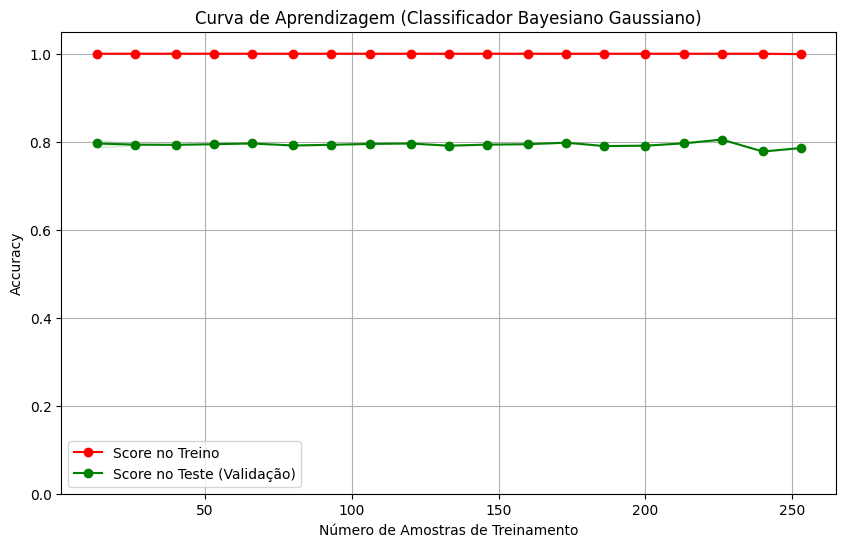


--- Comentários sobre a Curva de Aprendizagem ---
Score final no Treino (253 amostras): 0.9992
Score final no Teste (14 amostras): 0.7857
Gap entre Treino e Teste (final): 0.2135
Comentário: A curva sugere possível **Alta Variância (Overfitting)**.
  - Há um gap significativo entre o score de treino (alto) e o score de teste (mais baixo).
  - O score de teste pode melhorar com mais dados de treinamento.
  - Possíveis soluções: Adicionar mais dados de treino, aumentar regularização (epsilon maior?), reduzir complexidade do modelo/features (ex: PCA).
  - A curva de teste parece ter estabilizado (achatado).


In [10]:
from sklearn.model_selection import train_test_split
# --- 5. Curva de Aprendizagem ---
print("\n--- Gerando Curva de Aprendizagem ---")

n_classes = 2
# Definir as proporções do conjunto de treino a serem usadas
train_sizes_proportions = np.linspace(0.05, 0.95, 19) # 5% a 95% com passo de 5%
n_splits_learning_curve = 5 # Repetir cada tamanho de treino N vezes para suavizar

# Armazenar resultados médios
train_scores_mean = []
train_scores_std = []
test_scores_mean = []
test_scores_std = []
train_sizes_abs = [] # Tamanho absoluto do treino

# Usaremos Acurácia como métrica para a curva (poderia ser outra)
metric_lc = 'accuracy' # Ou 'error_rate', etc.

for i, p in enumerate(train_sizes_proportions):
    current_train_size = int(p * X.shape[0])
    current_test_size = X.shape[0] - current_train_size # O restante
    print(f"  Processando tamanho de treino: {p*100:.1f}% ({current_train_size} amostras)")

    # Listas para armazenar scores desta proporção nas N repetições
    current_train_scores = []
    current_test_scores = []

    if current_train_size < n_classes or current_test_size < n_classes:
         print(f"    AVISO: Tamanho de treino ({current_train_size}) ou teste ({current_test_size}) muito pequeno para garantir todas as classes. Pulando.")
         # Adicionar NaNs para manter o tamanho dos arrays de resultado
         train_scores_mean.append(np.nan)
         train_scores_std.append(np.nan)
         test_scores_mean.append(np.nan)
         test_scores_std.append(np.nan)
         train_sizes_abs.append(current_train_size)
         continue

    for split in range(n_splits_learning_curve):
        # Dividir o conjunto *original* estratificadamente
        # random_state muda a cada split para ter amostragens diferentes
        try:
            X_train_lc, X_test_lc, y_train_lc, y_test_lc = train_test_split(
                X, y,
                train_size=p,
                test_size=1-p,
                stratify=y,
                random_state=42 + split # Semente diferente para cada repetição
            )
        except ValueError as e:
             # Pode acontecer se uma classe tiver poucas amostras e a estratificação falhar
             print(f"    AVISO: Falha ao dividir os dados para p={p:.2f}, split={split+1}. Erro: {e}. Pulando este split.")
             continue # Pula para o próximo split


        # Verificar se ambas as classes estão presentes (importante para covariância)
        if len(np.unique(y_train_lc)) < n_classes:
             print(f"    AVISO: Treino (p={p:.2f}, split={split+1}) não contém todas as classes. Pulando este split.")
             continue
        if len(np.unique(y_test_lc)) < n_classes:
             # Menos crítico para teste, mas a métrica pode não fazer sentido (ex: precisão para classe ausente)
             pass # Continuar, mas ciente

        # Treinar o modelo no conjunto de treino atual (p%)
        model_lc = GaussianBayesClassifier(reg_epsilon=1e-6)
        try:
            model_lc.fit(X_train_lc, y_train_lc)

            # Avaliar no conjunto de treino (p%)
            y_pred_train_lc = model_lc.predict(X_train_lc)
            train_score = accuracy_score(y_train_lc, y_pred_train_lc)
            current_train_scores.append(train_score)

            # Avaliar no conjunto de teste ((100-p)%)
            y_pred_test_lc = model_lc.predict(X_test_lc)
            test_score = accuracy_score(y_test_lc, y_pred_test_lc)
            current_test_scores.append(test_score)

        except LinAlgError as e:
             print(f"    AVISO: Falha ao treinar/prever para p={p:.2f}, split={split+1} devido a erro de álgebra linear: {e}. Pulando este split.")
             # Não adicionar scores para este split
             pass
        except Exception as e:
             print(f"    AVISO: Erro inesperado para p={p:.2f}, split={split+1}: {e}. Pulando este split.")
             pass


    # Calcular média e desvio padrão dos scores para esta proporção p
    if current_train_scores: # Se houve splits válidos
        train_scores_mean.append(np.mean(current_train_scores))
        train_scores_std.append(np.std(current_train_scores))
    else:
        train_scores_mean.append(np.nan)
        train_scores_std.append(np.nan)

    if current_test_scores:
        test_scores_mean.append(np.mean(current_test_scores))
        test_scores_std.append(np.std(current_test_scores))
    else:
        test_scores_mean.append(np.nan)
        test_scores_std.append(np.nan)

    train_sizes_abs.append(current_train_size)

# Converter para arrays numpy
train_scores_mean = np.array(train_scores_mean)
train_scores_std = np.array(train_scores_std)
test_scores_mean = np.array(test_scores_mean)
test_scores_std = np.array(test_scores_std)
train_sizes_abs = np.array(train_sizes_abs)

# Remover NaNs que podem ter surgido de splits inválidos
valid_indices = ~np.isnan(train_scores_mean) & ~np.isnan(test_scores_mean)
train_sizes_abs = train_sizes_abs[valid_indices]
train_scores_mean = train_scores_mean[valid_indices]
train_scores_std = train_scores_std[valid_indices]
test_scores_mean = test_scores_mean[valid_indices]
test_scores_std = test_scores_std[valid_indices]


# --- Plotar Curva de Aprendizagem ---
plt.figure(figsize=(10, 6))
plt.title("Curva de Aprendizagem (Classificador Bayesiano Gaussiano)")
plt.xlabel("Número de Amostras de Treinamento")
plt.ylabel(f"{metric_lc.title()}")
plt.grid(True)

# Plotar médias
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Score no Treino")
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Score no Teste (Validação)")

# Plotar área de desvio padrão (opcional)
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")

plt.legend(loc="best")
plt.ylim(0.0, 1.05) # Limites do eixo Y para acurácia
plt.show()

# --- Comentários sobre a Curva de Aprendizagem ---
print("\n--- Comentários sobre a Curva de Aprendizagem ---")
if len(train_sizes_abs) > 0:
    final_train_score = train_scores_mean[-1]
    final_test_score = test_scores_mean[-1]
    gap = final_train_score - final_test_score

    print(f"Score final no Treino ({train_sizes_abs[-1]} amostras): {final_train_score:.4f}")
    print(f"Score final no Teste ({X.shape[0]-train_sizes_abs[-1]} amostras): {final_test_score:.4f}")
    print(f"Gap entre Treino e Teste (final): {gap:.4f}")

    if final_test_score < 0.7 and gap < 0.1: # Exemplo de limiares
        print("Comentário: A curva sugere possível **Alto Viés (Underfitting)**.")
        print("  - Ambos os scores (treino e teste) parecem ter convergido para um valor relativamente baixo.")
        print("  - Adicionar mais dados pode não melhorar significativamente o desempenho no teste.")
        print("  - Possíveis soluções: Usar um modelo mais complexo, adicionar/melhorar features, reduzir regularização (se aplicável).")
    elif gap > 0.2: # Exemplo de limiar para gap grande
        print("Comentário: A curva sugere possível **Alta Variância (Overfitting)**.")
        print("  - Há um gap significativo entre o score de treino (alto) e o score de teste (mais baixo).")
        print("  - O score de teste pode melhorar com mais dados de treinamento.")
        print("  - Possíveis soluções: Adicionar mais dados de treino, aumentar regularização (epsilon maior?), reduzir complexidade do modelo/features (ex: PCA).")
    else:
        print("Comentário: O desempenho parece razoável.")
        print("  - O gap entre treino e teste não é excessivamente grande e os scores podem estar convergindo.")
        print("  - Analise o nível de desempenho final para ver se atende aos requisitos.")

    # Analisar a tendência das curvas:
    if len(train_sizes_abs) > 5: # Se tivermos pontos suficientes
         slope_test, _, _, _, _ = stats.linregress(train_sizes_abs[-5:], test_scores_mean[-5:])
         if slope_test > 0.001: # Se a curva de teste ainda está subindo significativamente
             print("  - A curva de teste ainda mostra uma tendência de melhora com mais dados.")
         else:
             print("  - A curva de teste parece ter estabilizado (achatado).")

else:
    print("Não foi possível gerar a curva de aprendizagem devido à falta de pontos válidos.")